In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')
import os
import datetime
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from cairosvg import svg2png
from io import BytesIO
from PIL import Image

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import os
from cairosvg import svg2png
from io import BytesIO
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to convert SVG to PNG
def svg_to_png(svg_path, size=(224, 224)):
    try:
        with open(svg_path, 'rb') as svg_file:
            svg_data = svg_file.read()
        png_data = svg2png(bytestring=svg_data, output_width=size[0], output_height=size[1], background_color='white')
        img = Image.open(BytesIO(png_data))
        
        # Convert to RGB if the image is not already in RGB mode
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Convert to numpy array
        img_array = np.array(img)
        
        # Invert colors to make lines black and background white
        img_array = 255 - img_array
        
        # Threshold the image to make it binary
        threshold = 128
        img_array = np.where(img_array < threshold, 0, 255).astype(np.uint8)
        
        return img_array
    except Exception as e:
        print(f"Error processing {svg_path}: {str(e)}")
        return np.full((*size, 3), 255, dtype=np.uint8)  # White image for errors

# Custom data generator for SVG files
class SVGDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, target_size=(224, 224), batch_size=32, class_mode='categorical'):
        class_indices = {}
        classes = []
        all_svg_files = []

        for i, class_name in enumerate(sorted(os.listdir(directory))):
            class_path = os.path.join(directory, class_name)
            if os.path.isdir(class_path):
                class_indices[class_name] = i
                svg_files = [f for f in os.listdir(class_path) if f.lower().endswith('.svg')]
                all_svg_files.extend([(os.path.join(class_path, f), i) for f in svg_files])
                classes.extend([i] * len(svg_files))

        def generate_batches():
            while True:
                np.random.shuffle(all_svg_files)
                for i in range(0, len(all_svg_files), batch_size):
                    batch_files = all_svg_files[i:i+batch_size]
                    batch_images = []
                    batch_labels = []
                    for file_path, label in batch_files:
                        try:
                            img_array = svg_to_png(file_path, target_size)
                            img_array = img_array.astype(np.float32) / 255.0
                            batch_images.append(img_array)
                            batch_labels.append(label)
                        except Exception as e:
                            print(f"Error processing {file_path}: {str(e)}")
                    yield np.array(batch_images), np.array(batch_labels)

        return generate_batches(), len(all_svg_files), class_indices


In [78]:

# Set up data generator
data_gen = SVGDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.3
)

# Load and prepare the data
generator, total_samples, class_indices = data_gen.flow_from_directory(
    'svg/',
    target_size=(224, 224),
    batch_size=32
)

print(f"Total samples: {total_samples}")
print(f"Class indices: {class_indices}")

Total samples: 20000
Class indices: {'airplane': 0, 'alarm clock': 1, 'angel': 2, 'ant': 3, 'apple': 4, 'arm': 5, 'armchair': 6, 'ashtray': 7, 'axe': 8, 'backpack': 9, 'banana': 10, 'barn': 11, 'baseball bat': 12, 'basket': 13, 'bathtub': 14, 'bear (animal)': 15, 'bed': 16, 'bee': 17, 'beer-mug': 18, 'bell': 19, 'bench': 20, 'bicycle': 21, 'binoculars': 22, 'blimp': 23, 'book': 24, 'bookshelf': 25, 'boomerang': 26, 'bottle opener': 27, 'bowl': 28, 'brain': 29, 'bread': 30, 'bridge': 31, 'bulldozer': 32, 'bus': 33, 'bush': 34, 'butterfly': 35, 'cabinet': 36, 'cactus': 37, 'cake': 38, 'calculator': 39, 'camel': 40, 'camera': 41, 'candle': 42, 'cannon': 43, 'canoe': 44, 'car (sedan)': 45, 'carrot': 46, 'castle': 47, 'cat': 48, 'cell phone': 49, 'chair': 50, 'chandelier': 51, 'church': 52, 'cigarette': 53, 'cloud': 54, 'comb': 55, 'computer monitor': 56, 'computer-mouse': 57, 'couch': 58, 'cow': 59, 'crab': 60, 'crane (machine)': 61, 'crocodile': 62, 'crown': 63, 'cup': 64, 'diamond': 65, 

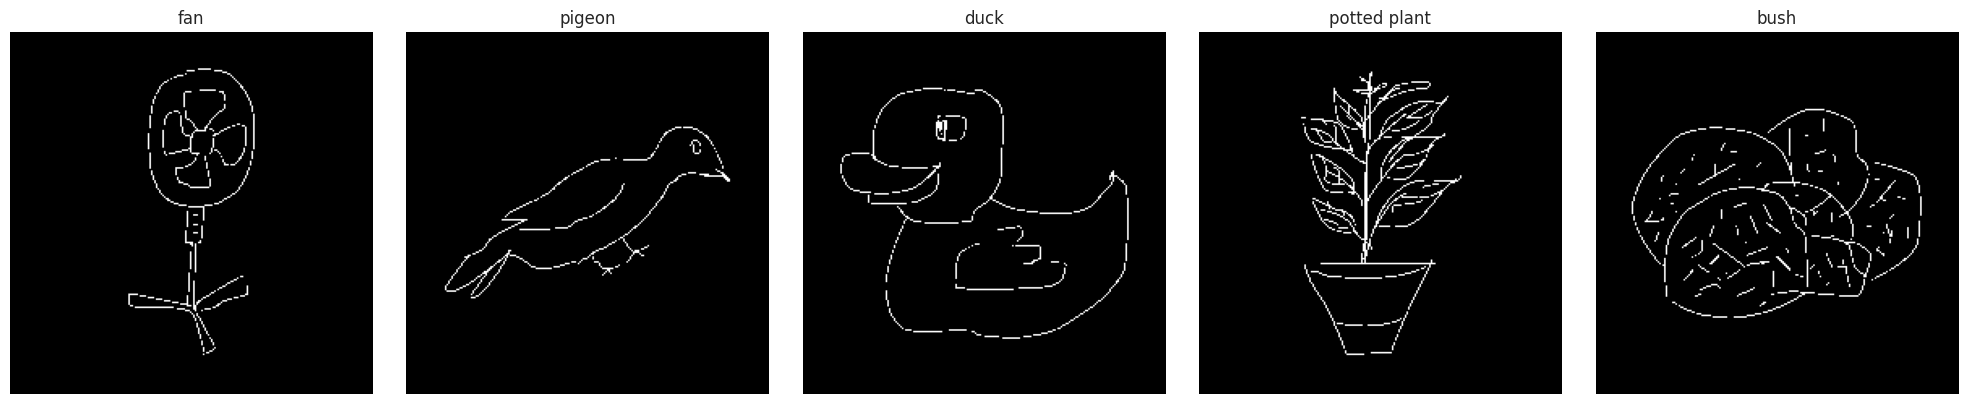

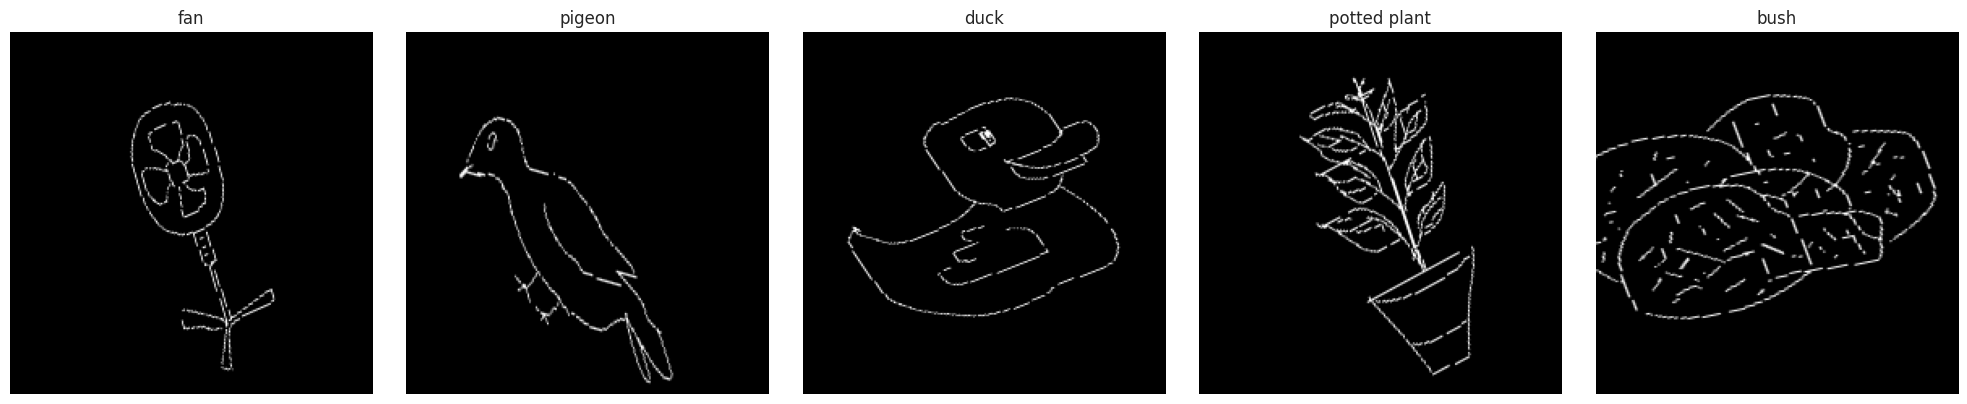

In [79]:
# Visualize some images
def plot_images(images, labels, n=5):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)  # Use grayscale colormap
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images and labels
images, labels = next(generator)

# Convert numeric labels back to class names
label_map = {v: k for k, v in class_indices.items()}
label_names = [label_map[label] for label in labels]  # Changed this line

# Plot original images
plot_images(images, label_names)

# Plot augmented images
augmented_images = []
augmented_labels = []
for image, label in zip(images[:5], label_names[:5]):  # Augment first 5 images
    augmented_image = data_gen.random_transform(image)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)

plot_images(augmented_images, augmented_labels)

In [73]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=20
)


ValueError: Unrecognized data type: x=<__main__.SVGIterator object at 0x7f1aa972a5a0> (of type <class '__main__.SVGIterator'>)

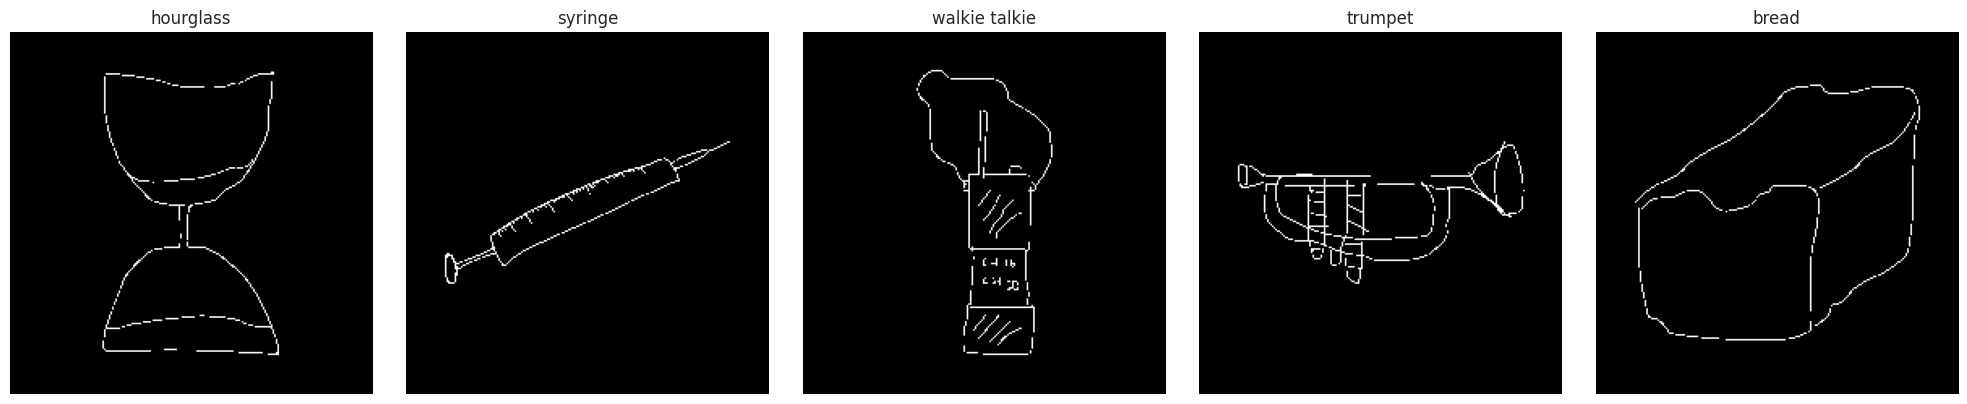

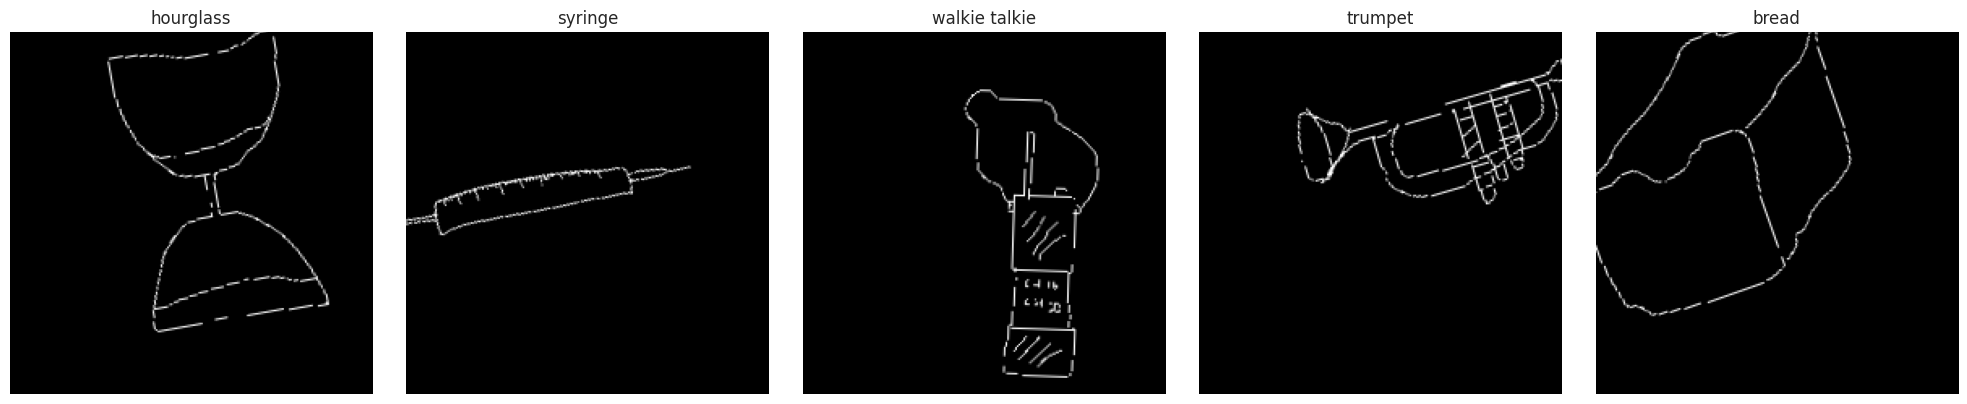

In [ ]:
# Visualize some images
def plot_images(images, labels, n=5):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)  # Use grayscale colormap
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images and labels
images, labels = next(generator)

# Convert numeric labels back to class names
label_map = {v: k for k, v in class_indices.items()}
label_names = [label_map[label] for label in labels]  # Changed this line

# Plot original images
plot_images(images, label_names)

# Plot augmented images
augmented_images = []
augmented_labels = []
for image, label in zip(images[:5], label_names[:5]):  # Augment first 5 images
    augmented_image = data_gen.random_transform(image)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)

plot_images(augmented_images, augmented_labels)

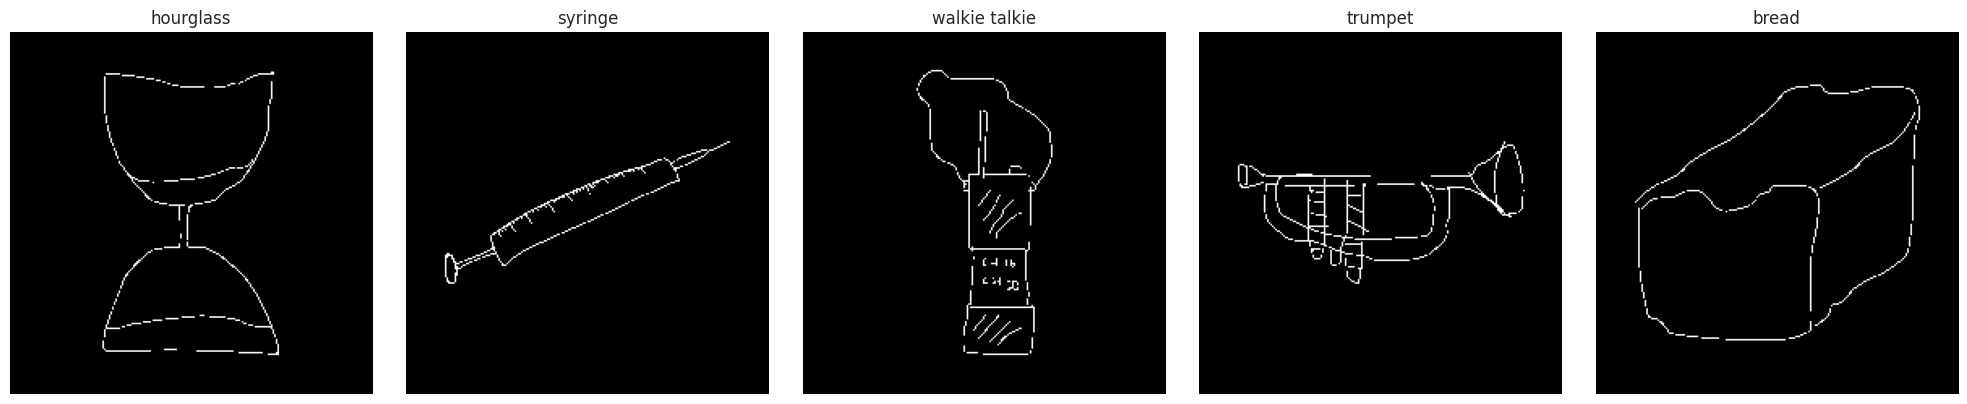

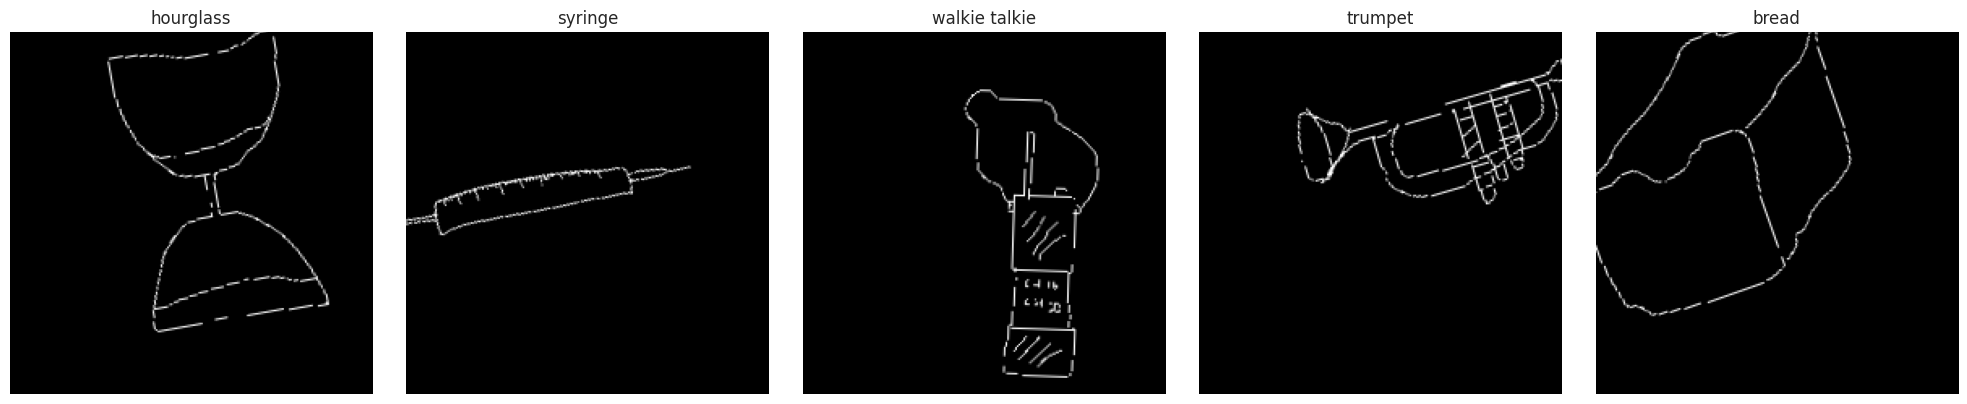

In [ ]:
# Visualize some images
def plot_images(images, labels, n=5):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)  # Use grayscale colormap
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images and labels
images, labels = next(generator)

# Convert numeric labels back to class names
label_map = {v: k for k, v in class_indices.items()}
label_names = [label_map[label] for label in labels]  # Changed this line

# Plot original images
plot_images(images, label_names)

# Plot augmented images
augmented_images = []
augmented_labels = []
for image, label in zip(images[:5], label_names[:5]):  # Augment first 5 images
    augmented_image = data_gen.random_transform(image)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)

plot_images(augmented_images, augmented_labels)

In [ ]:
# Fine-tuning: Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Continue training
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=10
)


In [ ]:
# Save the model
model.save('sketch_classifier_model.h5')